In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2023-02-13 09:30:47--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.69.240, 142.250.72.16, 142.250.72.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.69.240|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: '/tmp/sarcasm.json'

     0K .......... .......... .......... .......... ..........  0% 2.65M 2s
    50K .......... .......... .......... .......... ..........  1% 3.62M 2s
   100K .......... .......... .......... .......... ..........  2% 4.44M 2s
   150K .......... .......... .......... .......... ..........  3% 6.45M 1s
   200K .......... .......... .......... .......... ..........  4% 7.52M 1s
   250K .......... .......... .......... .......... ..........  5% 7.44M 1s
   300K .......... .......... .......... .......... ..........  6% 5.59M 1s
  

In [ ]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

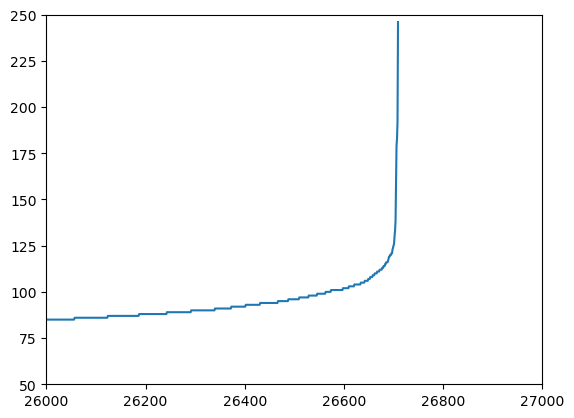

85


In [5]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.axis([26000, 27000, 50, 250])
plt.show()

print(newys[26000])
     

In [6]:
vocab_size = 8000
embedding_dim = 10
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 23000

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
     

In [9]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          80000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         88800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 24)                4824      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 414,449
Trainable params: 414,449
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
719/719 - 35s - loss: 0.6925 - accuracy: 0.5423 - val_loss: 0.6908 - val_accuracy: 0.5700
Epoch 2/30
719/719 - 26s - loss: 0.6878 - accuracy: 0.5596 - val_loss: 0.6826 - val_accuracy: 0.5700
Epoch 3/30
719/719 - 26s - loss: 0.6850 - accuracy: 0.5596 - val_loss: 0.6822 - val_accuracy: 0.5700
Epoch 4/30
719/719 - 26s - loss: 0.6845 - accuracy: 0.5596 - val_loss: 0.6816 - val_accuracy: 0.5700
Epoch 5/30
719/719 - 25s - loss: 0.6837 - accuracy: 0.5596 - val_loss: 0.6802 - val_accuracy: 0.5700
Epoch 6/30
719/719 - 26s - loss: 0.6818 - accuracy: 0.5596 - val_loss: 0.6765 - val_accuracy: 0.5700
Epoch 7/30
719/719 - 26s - loss: 0.6715 - accuracy: 0.5789 - val_loss: 0.6556 - val_accuracy: 0.6384
Epoch 8/30
719/719 - 26s - loss: 0.6389 - accuracy: 0.6468 - val_loss: 0.6213 - val_accuracy: 0.6587
Epoch 9/30
719/719 - 26s - loss: 0.6116 - accuracy: 0.6677 - val_loss: 0.6091 - val_accuracy: 0.6738
Epoch 10/30
719/719 - 26s - loss: 0.5981 - accuracy: 0.6859 - val_loss: 0.5940 - val_accura

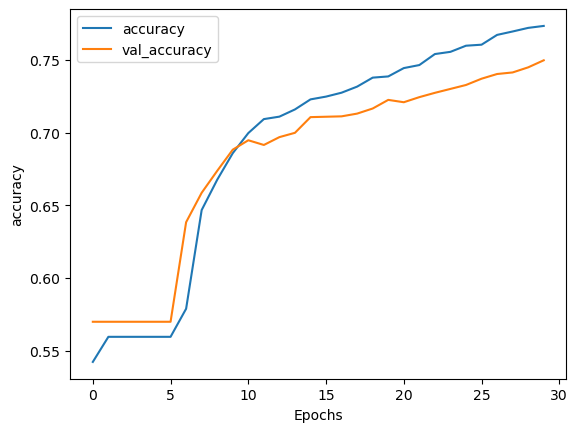

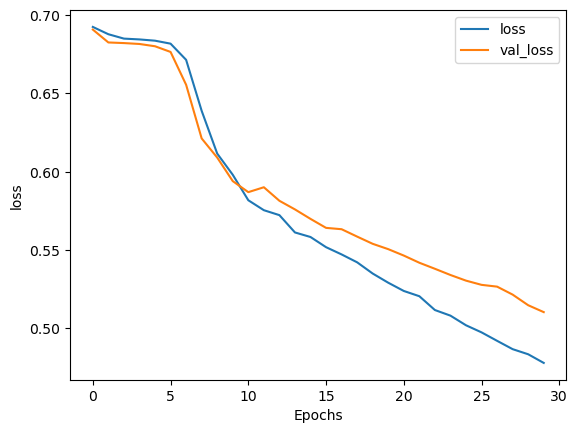

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]
sequences = tokenizer.texts_to_sequences(test_sentences)
#print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(padded)

predictions = model.predict(padded)
#print(predictions[:, max_length-1])

In [15]:
print(predictions)


[[0.93813354]
 [0.54031795]
 [0.9311332 ]
 [0.90108246]]
